# Mixture Models


Notebook to play around with the Iris dataset and Mixture Models


In [1]:
%load_ext nb_black
import seaborn as sns
import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<IPython.core.display.Javascript object>

In [2]:
iris_df = sns.load_dataset("iris")
iris_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


<IPython.core.display.Javascript object>

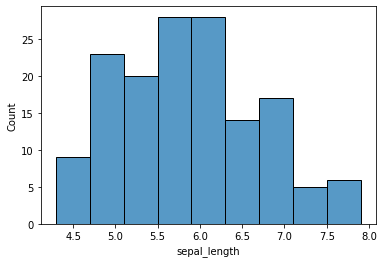

<IPython.core.display.Javascript object>

In [3]:
_ = sns.histplot(iris_df.sepal_length)

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_iris_df = scaler.fit_transform(iris_df.drop(columns=["species"]))
scaled_iris_df = pd.DataFrame(scaled_iris_df, columns=iris_df.columns[:4])
scaled_iris_df["species"] = iris_df["species"]
scaled_iris_df

,sepal_length,sepal_width,petal_length,petal_width,species
0,-0.900681,1.019004,-1.340227,-1.315444,setosa
1,-1.143017,-0.131979,-1.340227,-1.315444,setosa
2,-1.385353,0.328414,-1.397064,-1.315444,setosa
3,-1.506521,0.098217,-1.283389,-1.315444,setosa
4,-1.021849,1.249201,-1.340227,-1.315444,setosa
...,...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832,virginica
146,0.553333,-1.282963,0.705921,0.922303,virginica
147,0.795669,-0.131979,0.819596,1.053935,virginica
148,0.432165,0.788808,0.933271,1.448832,virginica


<IPython.core.display.Javascript object>

In [5]:
scaled_iris_df.groupby(["species"]).agg(
    mean_sepal_length=pd.NamedAgg(column="sepal_length", aggfunc="mean"),
    std_sepal_length=pd.NamedAgg(column="sepal_length", aggfunc="std"),
    mean_petal_length=pd.NamedAgg(column="petal_length", aggfunc="mean"),
    std_petal_length=pd.NamedAgg(column="petal_length", aggfunc="std"),
    mean_sepal_width=pd.NamedAgg(column="sepal_width", aggfunc="mean"),
    std_sepal_width=pd.NamedAgg(column="sepal_width", aggfunc="std"),
    mean_petal_width=pd.NamedAgg(column="petal_width", aggfunc="mean"),
    std_petal_width=pd.NamedAgg(column="petal_width", aggfunc="std"),
)

,mean_sepal_length,std_sepal_length,mean_petal_length,std_petal_length,mean_sepal_width,std_sepal_width,mean_petal_width,std_petal_width
species,,,,,,,,
setosa,-1.014579,0.427104,-1.304987,0.098706,0.853263,0.872594,-1.254893,0.138721
versicolor,0.112282,0.625434,0.285324,0.267085,-0.661432,0.722354,0.166734,0.260306
virginica,0.902297,0.770482,1.019663,0.313683,-0.191831,0.742377,1.088159,0.361528


<IPython.core.display.Javascript object>

In [6]:
data = scaled_iris_df.drop(columns=["species"]).values

<IPython.core.display.Javascript object>

In [ ]:
n_clusters = 4
n_observations, n_features = data.shape
with pm.Model() as model:
    chol, corr, stds = pm.LKJCholeskyCov(
        "chol",
        n=n_features,
        eta=2.0,
        sd_dist=pm.Exponential.dist(1.0),
        compute_corr=True,
    )
    cov = pm.Deterministic("cov", chol.dot(chol.T))
    μ = pm.Normal(
        "μ", 0.0, 1.5, shape=(n_clusters, n_features), testval=data.mean(axis=0)
    )

    p = pm.Dirichlet("p", a=np.ones(n_clusters))
    category = pm.Categorical("category", p=p, shape=n_observations)

    obs = pm.MvNormal("obs", μ[category], chol=chol, observed=data)

    trace = pm.sample(8000)


In [ ]:
with model:
    pm.plot_trace(trace[1000:])

In [ ]:
groups = [
    f"Group {n+1}"
    for n in list(trace.get_values("category", burn=6000, combine=False)[2][1400])
]
iris_df["group"] = groups
iris_df

In [ ]:
plot_df = (
    iris_df.groupby(["species", "group"])
    .count()[["sepal_length"]]
    .reset_index()
    .rename(columns={"sepal_length": "count"})
)
_ = sns.barplot(data=plot_df, x="species", y="count", hue="group")

In [ ]:
_ = sns.scatterplot(data=iris_df, x='sepal_length', y='petal_width', hue='group', style='species')


In [ ]:
_ = sns.barplot(data=plot_df, x="group", y="count", hue="species")

In [ ]:
with model:
    stats_df = az.from_pymc3(trace[6000:])

stats_df

In [8]:
from dmvgm import run_model

model_traces = {
    f"model_{i}_clusters": run_model(data, i, samples=8000) for i in range(2, 6)
}
comp = az.compare({k: v[1] for k, v in model_traces.items()})
comp

Building model with 2 cluster and 8000 samples.


C:\Git\MixedModels\dmvgm.py:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(samples)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, μ, chol]
>BinaryGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 426 seconds.
There were 1723 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6767532792026429, but should be close to 0.8. Try to increase the number of tuning steps.
There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Building model with 3 cluster and 8000 samples.


C:\Git\MixedModels\dmvgm.py:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(samples)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, μ, chol]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 469 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Building model with 4 cluster and 8000 samples.


C:\Git\MixedModels\dmvgm.py:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(samples)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, μ, chol]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 461 seconds.
C:\Users\Sebastian\.conda\envs\pymc3\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Building model with 5 cluster and 8000 samples.


C:\Git\MixedModels\dmvgm.py:26: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(samples)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [p, μ, chol]
>CategoricalGibbsMetropolis: [category]


Sampling 4 chains for 1_000 tune and 8_000 draw iterations (4_000 + 32_000 draws total) took 494 seconds.
There were 7547 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.03963479415510302, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2118 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6291825600980298, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6285690346033307, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\User

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_5_clusters,0,-209.618464,97.642757,0.000000,7.941642e-01,21.188884,0.000000,True,log
model_4_clusters,1,-214.980547,71.214702,5.362083,2.058358e-01,21.099624,4.429627,True,log
model_3_clusters,2,-284.203400,85.032008,74.584937,6.795874e-11,21.533758,9.150377,True,log
model_2_clusters,3,-471.380287,93.652148,261.761823,0.000000e+00,16.617773,12.822475,True,log


<IPython.core.display.Javascript object>

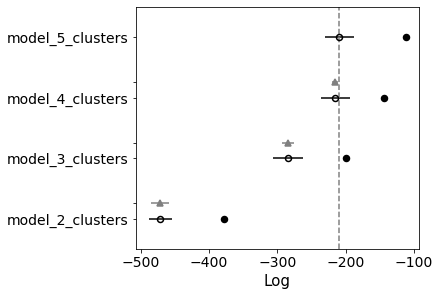

<IPython.core.display.Javascript object>

In [9]:
_ = az.plot_compare(comp)